Лабораторная работа №11 “Реализация криптографических атак с помощью машинного обучения на физически неклонируемые функции”
====
Лабораточная работа выполнена на языке **Python** c помощью интерактивной оболочки **Jupyter Notebook**
Исходный код работы - lab11.py.
Файл jupyter notebook - lab11.ipynb

## Ход работы

#### Сформулируем задачу в терминах машинного обучения

Поскольку ФНФ задается парами значений входных и соответствующим им выходных значений, которые называются парой запрос-ответ (Challenge-Response Pairs, CRP), то в простейшем случае ФНФ можно рассматривать как функцию, которая преобразует C(i) в ответы R(i):
R(i) = PUF(C(i))
Т.е. задачей машинного обучения будет задача найти максимально точное приближение данной функции, если нам даны точные параметры запроса и другие пары запрос-ответ.
Как входные данные используем набор пар запрос ответ (CRP), запрос представляет из себя массив бинарных значений (0 или 1) и соответствующий ему ответ бинарное значение 0 или 1. 
Т.е. получаем задачу классификации, где на вход получаем массив бинарных данных, где каждое значение это отдельный признак и 2 класса для классификации.

Для начала рассмотрим набор простейших ФНФ - Arbiter. В физических устройствах они реализуются так, использую значения запроса строится 2 пути одинакой длины на схеме устройста, после чего идет сигнал по обоим путям, при установлении каждого бита есть аппартная задержка уникальная для устройста и в итоге выбирается путь, который завершился быстрее, т.е. на выход получаем 0 или 1 в зависимости от результата.
Сгенерируем данные для данного вида ФНФ, массив задержек сгенерируем используя стандартное нормальное распределение, а набор запросов выберем из всех возможных запросов использую равномерное распределение. Будем использовать размер входного запроса 32 бит.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from utils import LinArbPUF
import sklearn
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [6]:
num_features = 32
num_examples = 10000
arb_puf = LinArbPUF(num_features)
challenges = arb_puf.generate_challenge(num_examples)
X = arb_puf.calc_features(challenges)
y = arb_puf.bin_response(X)
X = X.T

Для обучения модели попробуем использовать различные алгоритмы: Логистическую регрессию, градиентный бустинг, метод опорных векторов, нейронную сеть.
Поскольку в данной задаче нам важно только правильно предсказать класс для входных данных и не важно какой именно это класс, то для оценки качества будем исползовать долю правильных ответов (Accuracy).

#### Реализуем функцию, которая будет по заданным параметрам и входным данным стоить модель и считать результаты

In [9]:
def build_model(X, y, clf):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25)
    clf.fit(X_train, y_train)
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [10]:
def test_dataset_size(X, y, sizes, clf):
    trains = []
    tests = []
    for size in sizes:
        train_score, test_score = build_model(X[:size], y[:size], clf)
        trains.append(train_score)
        tests.append(test_score)

    plt.figure(figsize=(10, 8))
    plt.plot(sizes, trains, c='b')
    plt.plot(sizes, tests, c='r')
    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')
    plt.legend(['Train Score', 'Test Score'])
    plt.show()
    
    return tests

#### Проверим как справляется с задачей Логистическая регрессия

In [18]:
train_score, test_score = build_model(X, y, clf=sklearn.linear_model.LogisticRegression(solver='liblinear'))
print('Logistic Regression for 32-bit Arbiter PUF, dataset size 10_000')
print(f'Training score: {train_score}, Test score: {test_score}')

Logistic Regression for 32-bit Arbiter PUF, dataset size 10_000
Training score: 0.9965333333333334, Test score: 0.9936


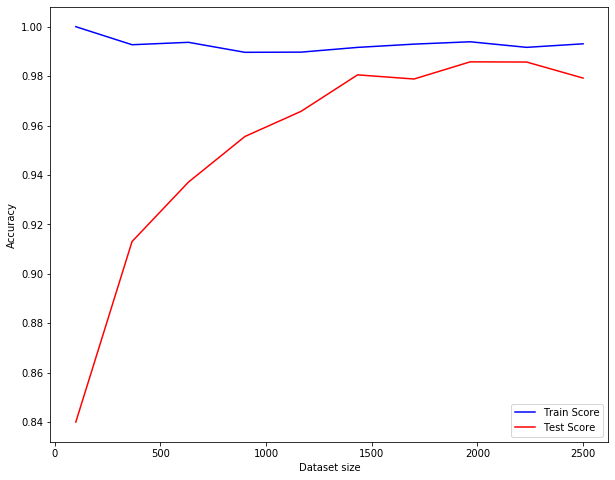

In [59]:
sizes = np.linspace(100, 2500, 10, dtype=int)
log_reg_scores = test_dataset_size(X, y, sizes, clf=sklearn.linear_model.LogisticRegression(solver='liblinear'))

Как видно из результатов мы достигли довольно высокой точности работы на большой выборке, больше 99%. На графике видна зависимость точности предсказаний от размера данных. Точности в 95% получилось достичь когда размер набора данных приблизился к тысяче.

#### Проверим как справляется с задачей метод опорных векторов

In [20]:
train_score, test_score = build_model(X, y, clf=SVC(C=1, gamma='scale'))
print('Support Vector Machine for 32-bit Arbiter PUF, dataset size 10_000')
print(f'Training score: {train_score}, Test score: {test_score}')

Support Vector Machine for 32-bit Arbiter PUF, dataset size 10_000
Training score: 0.9977333333333334, Test score: 0.9716


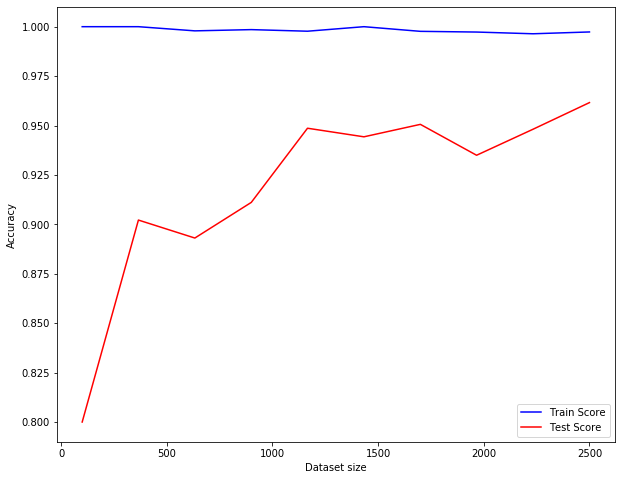

In [60]:
svd_scores = test_dataset_size(X, y, sizes, clf=SVC(C=1, gamma='scale'))

Как видим метод опорных векторов справился с задачей немного хуже чем логистическая регрессия, хотя 95% точности было достигнутся на таком же размере набора данных, около 1000.

#### Проверим как справляется с задачей метод градиентного бустинга

In [61]:
train_score, test_score = build_model(X, y, clf=GradientBoostingClassifier(n_estimators=400, max_depth=3))
print('Gradient boosting for 32-bit Arbiter PUF, dataset size 10_000')
print(f'Training score: {train_score}, Test score: {test_score}')

Gradient boosting for 32-bit Arbiter PUF, dataset size 10_000
Training score: 0.9910666666666667, Test score: 0.956


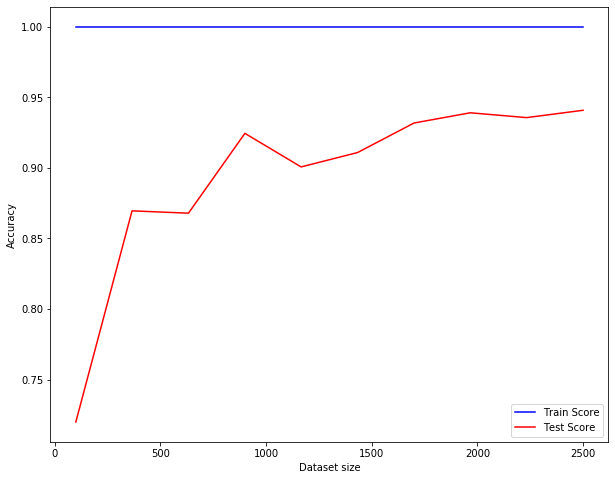

In [64]:
gb_scores = test_dataset_size(X, y, sizes, clf=GradientBoostingClassifier(n_estimators=400, max_depth=3))

Используя метод градиентного бустинга основанных на решающих деревьях, получилось добится неплохи результатов используя большое количество отдельных решаюших деревьев и их небольшую глубину.

#### Проверим как справляется с задачей нейронная сеть с одним скрытым слоем

In [46]:
train_score, test_score = build_model(X, y, clf=MLPClassifier(hidden_layer_sizes=(32), alpha=1e-3, batch_size=1000, max_iter=1000))
print('NN for 32-bit Arbiter PUF, dataset size 10_000')
print(f'Training score: {train_score}, Test score: {test_score}')

NN for 32-bit Arbiter PUF, dataset size 10_000
Training score: 1.0, Test score: 0.986


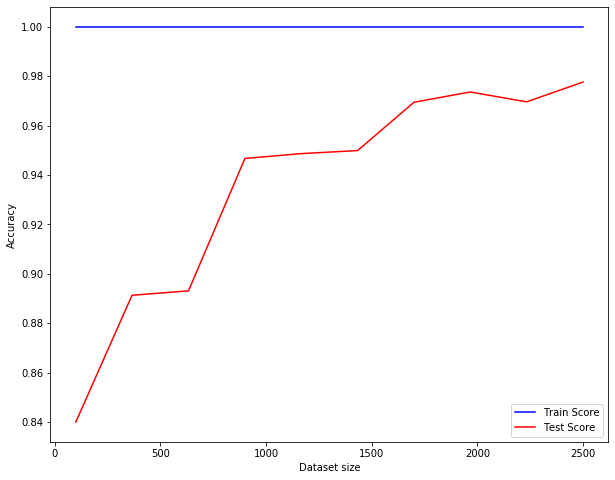

In [65]:
nn_scores = test_dataset_size(X, y, sizes, clf=MLPClassifier(hidden_layer_sizes=(32), alpha=1e-3, max_iter=1000))

На выборке большого размера получили результат близкий к 99%, точность в 95% была достигнута на выборке размера около тысячи.

#### Сравним полученные результаты

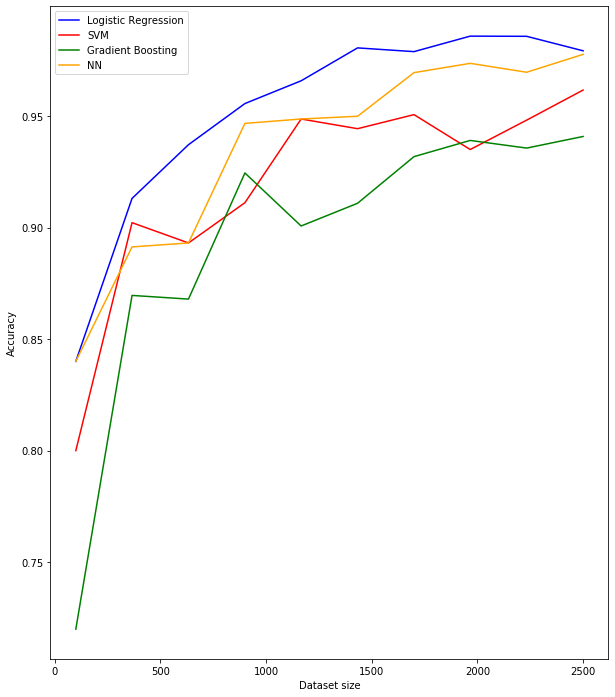

In [66]:
plt.figure(figsize=(10, 12))
plt.plot(sizes, log_reg_scores, c='b')
plt.plot(sizes, svd_scores, c='r')
plt.plot(sizes, gb_scores, c='g')
plt.plot(sizes, nn_scores, c='orange')
plt.xlabel('Dataset size')
plt.ylabel('Accuracy')
plt.legend(['Logistic Regression', 'SVM', 'Gradient Boosting', 'NN'])
plt.show()

Видно что для простых Arbiter ФНФ хорошо справляется логистическая регрессия, она работает стабильней, хотя стоит заметить судя по графику в итоге все кривые стресятся приблизительно в одну точку.

#### Проверим работу данных моделей на исходных данных

In [7]:
def read_puf_data(filename):
    raw_data = np.genfromtxt(filename, delimiter=' ', dtype=str)
    target = np.squeeze(raw_data[:, 1]).astype(int)
    data = [list(str) for str in raw_data[:, 0]]
    data = np.array(data, dtype=float)
    return data, target

In [8]:
base8_X, base8_y = read_puf_data('Base8.txt')

In [11]:
import matplotlib.cm as cm

def test_models(models, names, X, y, sizes):
    models_scores = []
    for model, name in zip(models, names):
        train_score, test_score = build_model(X, y, clf=model)
        print(f'{name}, dataset size {X.shape[0]}')
        print(f'Training score: {train_score}, Test score: {test_score}')
        scores = test_dataset_size(X, y, sizes, clf=model)
        models_scores.append(scores)

    plt.figure(figsize=(10, 12))
    colors = cm.rainbow(np.linspace(0, 1, len(models_scores)))
    for i, sc in enumerate(models_scores):
        plt.plot(sizes, sc, c=colors[i])

    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')
    plt.legend(names)
    plt.show()

Logistic Regression, dataset size 10000
Training score: 0.7317333333333333, Test score: 0.728


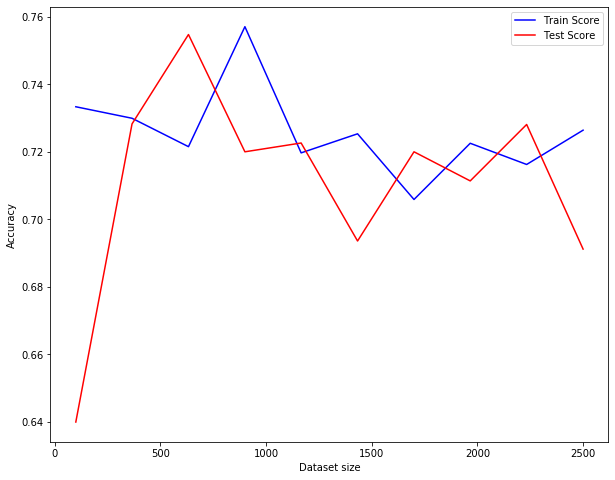

Gradient boosting, dataset size 10000
Training score: 1.0, Test score: 1.0


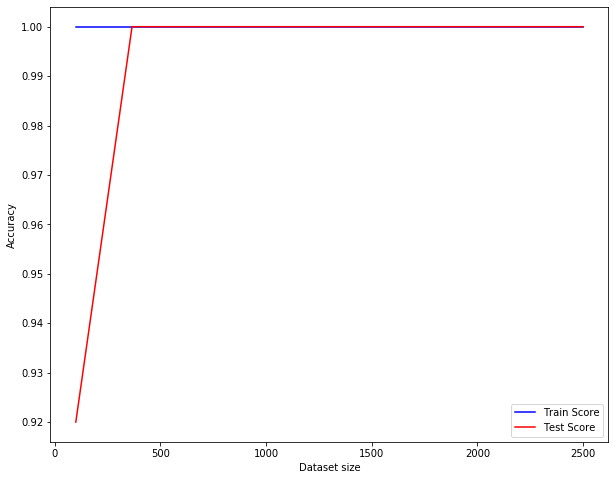

SVM, dataset size 10000
Training score: 1.0, Test score: 1.0


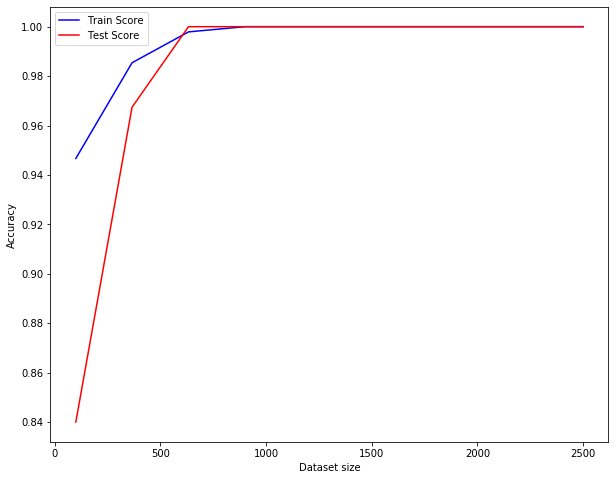

NN, dataset size 10000
Training score: 1.0, Test score: 1.0


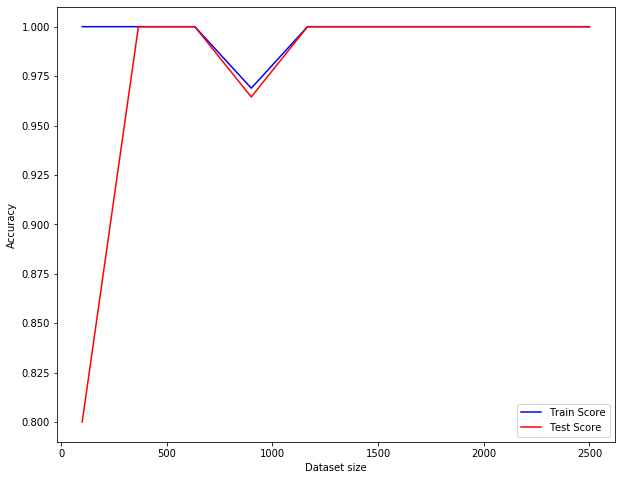

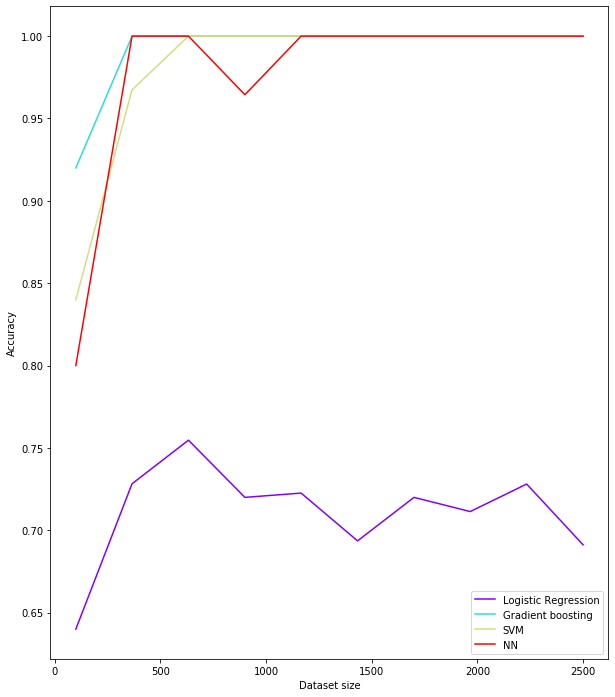

In [12]:
lr_clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
gb_clf = GradientBoostingClassifier(n_estimators=500, max_depth=3)
svm_clf = SVC(C=1, gamma='scale')
nn_clf = MLPClassifier(hidden_layer_sizes=(8, 8, 8), alpha=1e-3, max_iter=1000)

models = [lr_clf, gb_clf, svm_clf, nn_clf]
names = ['Logistic Regression', 'Gradient boosting', 'SVM', 'NN']
test_models(models, names, base8_X[:10000], base8_y[:10000], sizes=np.linspace(100, 2500, 10, dtype=int))

Как видно из результатов, на наборе данных из "Base8.txt" логистическая регрессия работает хуже всего, при этом остальные алгоритмы показывают максимальный результат. Похоже что исходные данные были созданые используя модель более сложной ФНФ, чем простой Arbiter ФНФ.

#### Проверим работу моделей на данных Base16.txt

In [14]:
base16_X, base16_y = read_puf_data('Base16.txt')

Logistic Regression, dataset size 10000
Training score: 0.6017333333333333, Test score: 0.6076


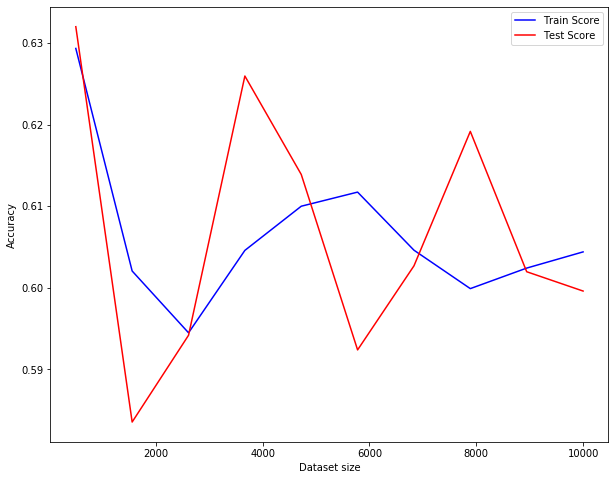

Gradient boosting, dataset size 10000
Training score: 0.7602666666666666, Test score: 0.6892


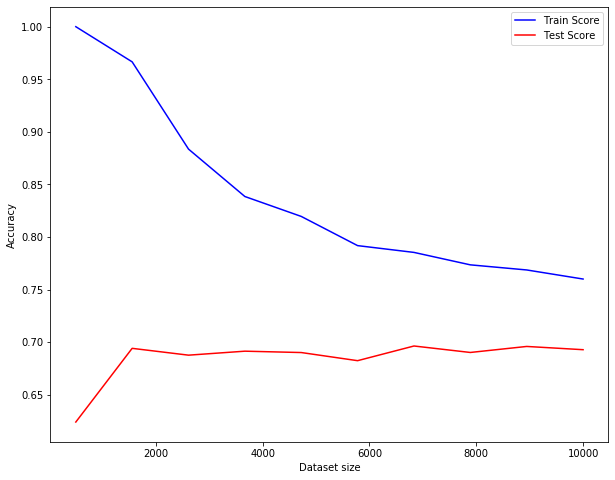

SVM, dataset size 10000
Training score: 0.7261333333333333, Test score: 0.7004


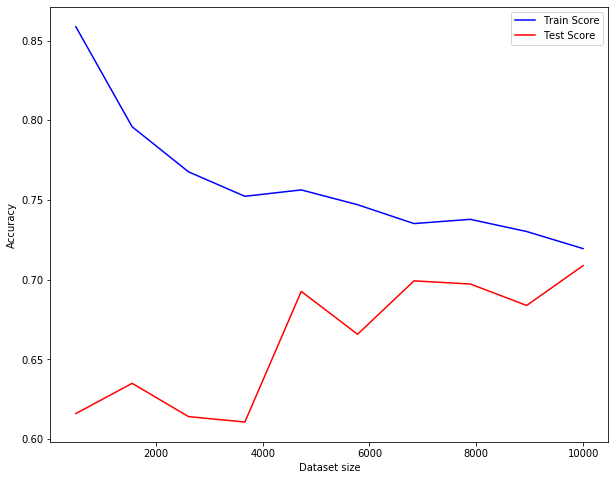

NN, dataset size 10000
Training score: 0.9682666666666667, Test score: 0.8272


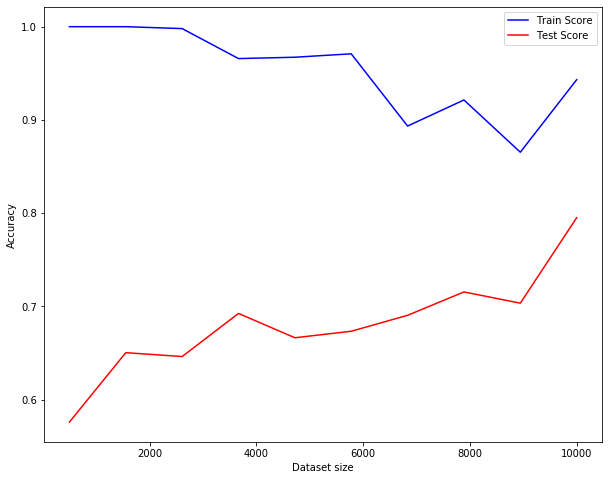

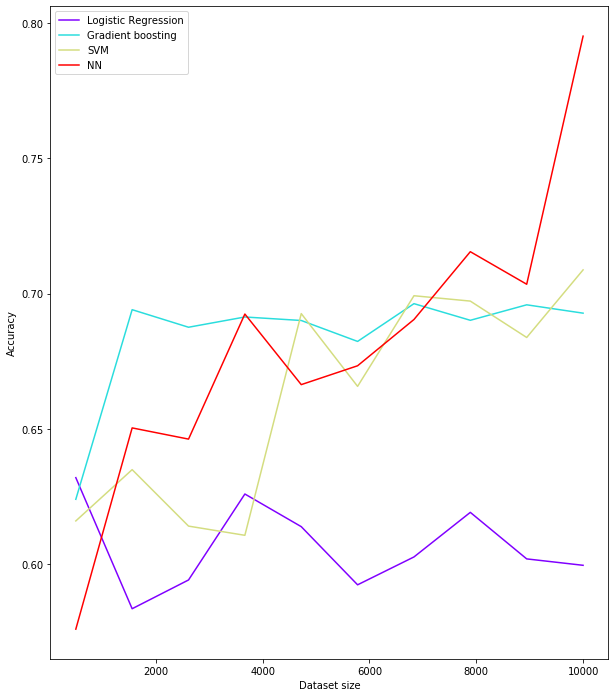

In [16]:
lr_clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
gb_clf = GradientBoostingClassifier(n_estimators=600, max_depth=4)
svm_clf = SVC(C=1, gamma='scale')
nn_clf = MLPClassifier(hidden_layer_sizes=(32, 32, 32), alpha=1e-3, max_iter=10000)

models = [lr_clf, gb_clf, svm_clf, nn_clf]
names = ['Logistic Regression', 'Gradient boosting', 'SVM', 'NN']
test_models(models, names, base16_X[:10000], base16_y[:10000], sizes=np.linspace(500, 10000, 10, dtype=int))

Как видно из результатов, на наборе данных из "Base16.txt" c усложнением исходных данных алгоритмы работают хуже, достойный результат показывает алгоритм нейронной сети с тремя скрытыми слоями.

#### Проверим работу моделей на данных Base24.txt

In [17]:
base24_X, base24_y = read_puf_data('Base24.txt')

Gradient boosting, dataset size 50000
Training score: 0.62792, Test score: 0.62392


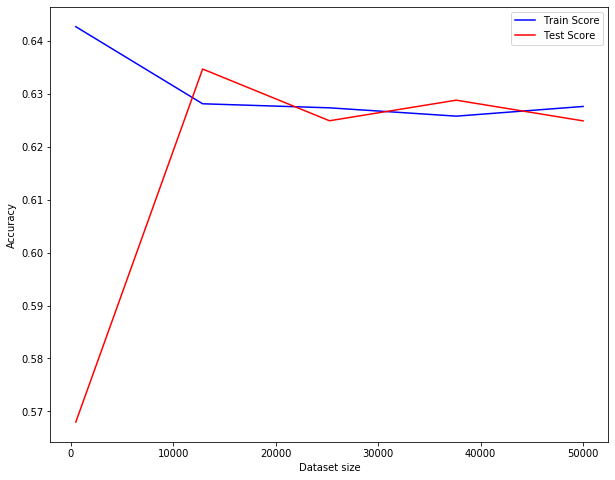

SVM, dataset size 50000
Training score: 0.6261866666666667, Test score: 0.62968


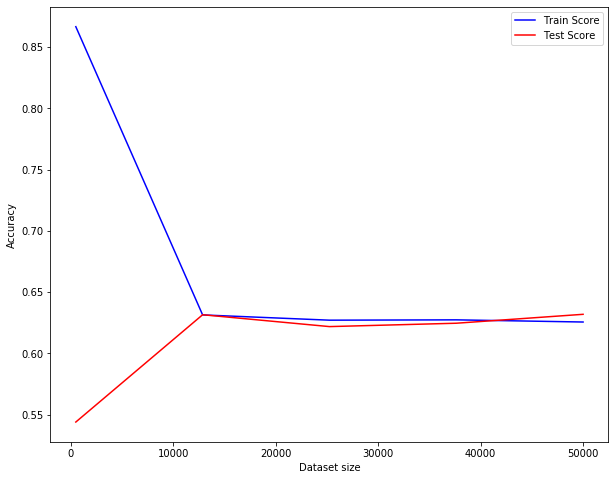

NN, dataset size 50000
Training score: 0.6265866666666666, Test score: 0.6312


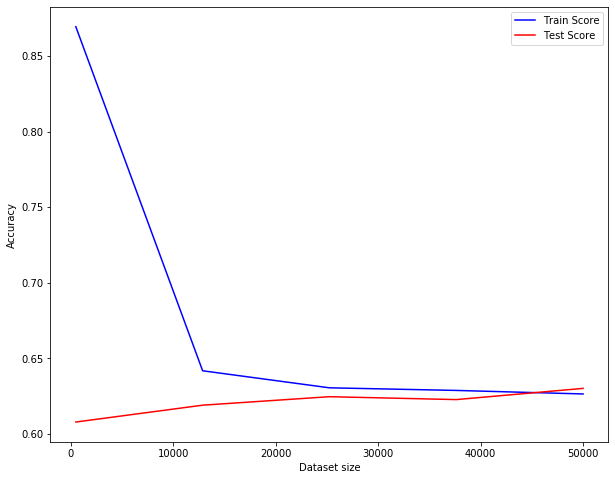

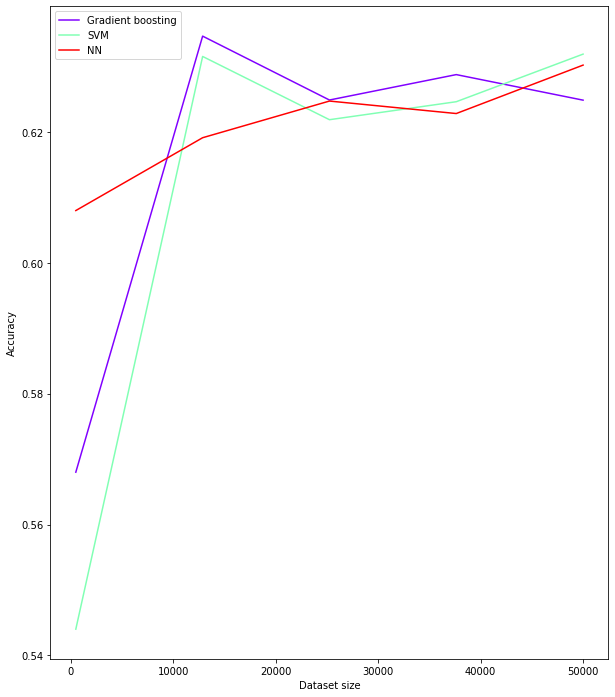

In [23]:
lr_clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
gb_clf = GradientBoostingClassifier(n_estimators=1000, max_depth=2)
svm_clf = SVC(C=1, gamma='scale')
nn_clf = MLPClassifier(hidden_layer_sizes=(32, 32, 32), alpha=1e-3, max_iter=10000, batch_size=1000)
models = [lr_clf, gb_clf, svm_clf, nn_clf]
names = ['Gradient boosting', 'SVM', 'NN']
test_models(models, names, base24_X[:50000], base24_y[:50000], sizes=np.linspace(500, 50000, 5, dtype=int))

Более хороших результатов удается добиться моделью нейнорой сети на большом наборе данных.

In [26]:
nn_clf = MLPClassifier(hidden_layer_sizes=(32, 32, 32), alpha=1e-3, max_iter=10000, batch_size=1000)
train_score, test_score = build_model(base24_X[:500000], base24_y[:500000], clf=nn_clf)
print(f'Training score: {train_score}\nTest score: {test_score}')

Training score: 0.775664
Test score: 0.76872


#### Проверим работу моделей на данных Base32.txt

In [27]:
base32_X, base32_y = read_puf_data('Base32.txt')

In [28]:
def test_models_without_plots(models, names, X, y):
    models_scores = []
    for model, name in zip(models, names):
        train_score, test_score = build_model(X, y, clf=model)
        print(f'{name}, dataset size {X.shape[0]}')
        print(f'Training score: {train_score}, Test score: {test_score}')

In [30]:
lr_clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
gb_clf = GradientBoostingClassifier(n_estimators=1000, max_depth=2)
svm_clf = SVC(C=1, gamma='scale')
nn_clf = MLPClassifier(hidden_layer_sizes=(32, 32, 32), alpha=1e-3, max_iter=10000, batch_size=1000)
models = [lr_clf, gb_clf, svm_clf, nn_clf]
names = ['Logistic Regression', 'Gradient boosting', 'SVM', 'NN']
test_models_without_plots(models, names, base32_X[:100000], base32_y[:100000])

Logistic Regression, dataset size 100000
Training score: 0.5468533333333333, Test score: 0.54472
Gradient boosting, dataset size 100000
Training score: 0.6040933333333334, Test score: 0.60244
SVM, dataset size 100000
Training score: 0.6373466666666666, Test score: 0.61768
NN, dataset size 100000
Training score: 0.7528266666666666, Test score: 0.72648


По результам видно что логистическая регрессия не справляется с задачей на входных запросах размером 32 бита, при этом нейронная сеть показывает приблизительно такой же результат, который можно улучшить увеличив размер данных, но это становиться затратно по времени выполнения.

## Вывод
В данной работе было иследованна возможность криптографических атак на физически неклонируемые функции, используя алгоритмы машинного обучения, в качесве алгоритмов были выбраны: логистическая регрессия, градиентный бустинг, метод опорных векторов и нейронная сеть. Приведенно сравнения результатов работы алгоритмов на различные виды ФНФ различных размеров входных запросов.